# Proteomics Practical Exercises

This notebook contains practical exercises covering computational proteomics concepts. Each exercise demonstrates key techniques used in modern proteomics research.

## Table of Contents
1. **Core Exercises**: UniProt API, PRIDE queries, peptide digestion, PSM matching
2. **Intermediate Exercises**: Spectrum prediction, RNA-protein modeling, phosphoproteomics, quantitative analysis
3. **Advanced Exercises**: Variant peptides, stability prediction, multiomics integration


In [2]:
# Import required libraries
import os
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, classification_report, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Set matplotlib style
plt.style.use('default')
%matplotlib inline


## Exercise 1: Query UniProt API for Protein Annotations

**Aim**: Learn how to call the UniProt REST API, parse JSON responses, extract protein domains, PTMs (Post Translational Modifications), and visualize domain architecture.

We'll query UniProt for TP53 (P04637) as an example.


Querying https://rest.uniprot.org/uniprotkb/P04637.json ...
Protein: P53_HUMAN
Protein length: 393 amino acids
Gene: TP53
Feature types: {'Modified residue', 'Site', 'Region', 'Mutagenesis', 'Binding site', 'Natural variant', 'Beta strand', 'Alternative sequence', 'Chain', 'Turn', 'Compositional bias', 'Motif', 'Cross-link', 'Helix', 'DNA binding'}

Found 0 domains
Found 13 phosphorylation sites
Found 17 other PTMs


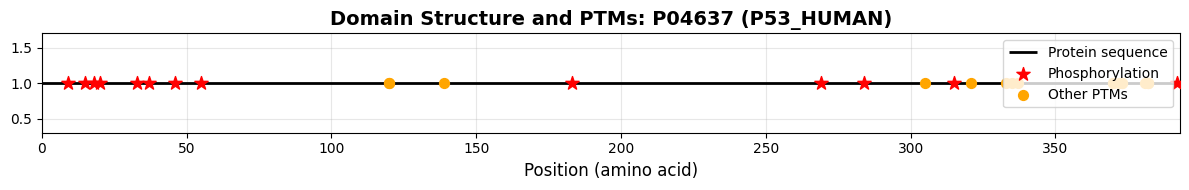


✓ Successfully retrieved and visualized P04637


In [21]:
# Exercise 1: UniProt API Query
protein_id = "P04637"  # TP53
url = f"https://rest.uniprot.org/uniprotkb/{protein_id}.json"
print(f"Querying {url} ...")

try:
    response = requests.get(url, timeout=10)
    response.raise_for_status()
    data = response.json()
    
    # Extract sequence
    seq = data["sequence"]["value"]
    print(f"Protein: {data.get('uniProtkbId', 'N/A')}")
    print(f"Protein length: {len(seq)} amino acids")
    print(f"Gene: {data.get('genes', [{}])[0].get('geneName', {}).get('value', 'N/A')}")
    
    # Extract features (domains & PTMs)
    features = data.get("features", [])
    
    domain_positions = []
    phospho_positions = []
    other_ptms = []

    feature_types = set([f["type"] for f in features])
    print(f"Feature types: {feature_types}")
    
    for f in features:
        if f["type"] == "Domain":
            start = f["location"]["start"]["value"]
            end = f["location"]["end"]["value"]
            domain_positions.append((start, end))
        elif f["type"] == "Modified residue":
            pos = f["location"]["start"]["value"]
            desc = f.get("description", "")
            if "Phospho" in desc:
                phospho_positions.append(pos)
            else:
                other_ptms.append((pos, desc))
    
    print(f"\nFound {len(domain_positions)} domains")
    print(f"Found {len(phospho_positions)} phosphorylation sites")
    print(f"Found {len(other_ptms)} other PTMs")
    
    # Plot domain architecture
    fig, ax = plt.subplots(figsize=(12, 2))
    ax.hlines(1, 0, len(seq), color="black", linewidth=2, label="Protein sequence")
    
    # Draw domains
    for (s, e) in domain_positions:
        ax.add_patch(plt.Rectangle((s, 0.7), e - s, 0.6, 
                                   color="skyblue", alpha=0.7, 
                                   edgecolor="navy", linewidth=1))
    
    # Mark phosphorylation sites
    if phospho_positions:
        ax.scatter(phospho_positions, [1] * len(phospho_positions), 
                  color="red", s=100, marker="*", zorder=5, label="Phosphorylation")
    
    # Mark other PTMs
    if other_ptms:
        other_pos = [p[0] for p in other_ptms]
        ax.scatter(other_pos, [1] * len(other_pos), 
                  color="orange", s=50, marker="o", zorder=4, label="Other PTMs")
    
    ax.set_title(f"Domain Structure and PTMs: {protein_id} ({data.get('uniProtkbId', 'N/A')})", 
                fontsize=14, fontweight='bold')
    ax.set_xlabel("Position (amino acid)", fontsize=12)
    ax.set_ylim(0.3, 1.7)
    ax.set_xlim(0, len(seq))
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Successfully retrieved and visualized {protein_id}")
    
except requests.exceptions.RequestException as e:
    print(f"Error querying UniProt: {e}")
except KeyError as e:
    print(f"Error parsing response: {e}")


## Exercise 2: Query PRIDE for Experiment Metadata

**Aim**: Learn API access, filtering, and metadata exploration. Visualize the distribution of experiments over time.


Querying PRIDE (first 100 projects)...
Retrieved 100 projects

Columns: ['accession', 'title', 'additionalAttributes', 'projectDescription', 'sampleProcessingProtocol', 'dataProcessingProtocol', 'projectTags', 'keywords', 'doi', 'submissionType', 'license', 'submissionDate', 'publicationDate', 'submitters', 'labPIs', 'instruments', 'softwares', 'experimentTypes', 'quantificationMethods', 'countries', 'sampleAttributes', 'organisms', 'organismParts', 'diseases', 'references', 'identifiedPTMStrings', 'totalFileDownloads', 'otherOmicsLinks']

First 3 projects:
   accession                                              title  \
0  PXD001357  Direct evidence of milk consumption from ancie...   
1  PXD000035         Surface Proteins of Listeria monocytogenes   
2  PXD000030  Annexin A1 interacting proteins in chronic mye...   

  publicationDate  
0      2015-02-25  
1      2013-08-27  
2      2013-08-13  


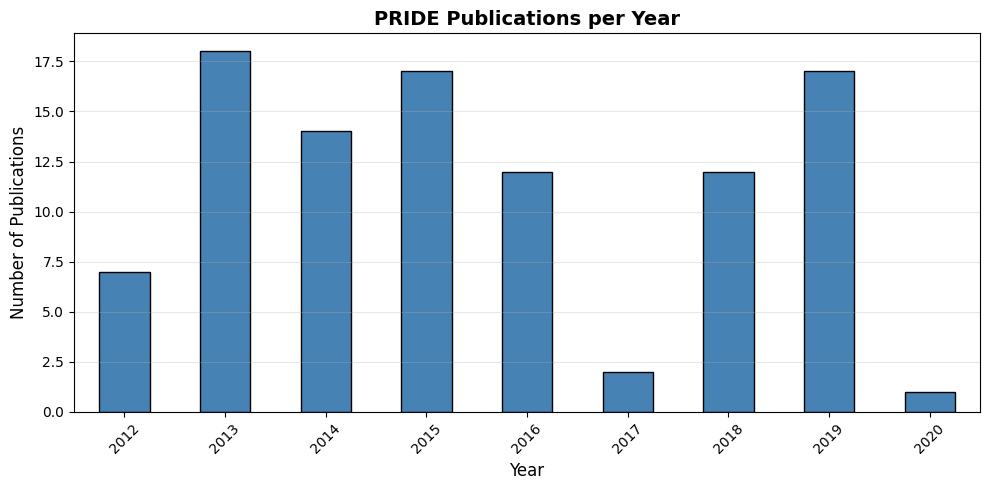


Year range: 2012 - 2020
Total projects: 100


In [15]:
# Exercise 2: PRIDE Query
# Using PRIDE API v3: https://www.ebi.ac.uk/pride/ws/archive/v3/

# Try PRIDE API v3 endpoint
url = "https://www.ebi.ac.uk/pride/ws/archive/v3/projects"
projects_count = 100
print(f"Querying PRIDE (first {projects_count} projects)...")
response = requests.get(url, params={"pageSize": projects_count, "page": 0}, timeout=15)

# Check if response is valid JSON
resp = None
if response.status_code == 200:
    try:
        resp = response.json()
        # PRIDE v3 API returns a different structure - check for content or _embedded
        if resp and isinstance(resp, dict):
            # v3 API might return data in _embedded.projects or directly as a list
            if "_embedded" in resp and "projects" in resp["_embedded"]:
                projects = resp["_embedded"]["projects"]
            elif "content" in resp:
                projects = resp["content"]
            elif isinstance(resp.get("projects"), list):
                projects = resp["projects"]
            else:
                # If it's a list directly, use it
                projects = resp if isinstance(resp, list) else None
        elif isinstance(resp, list):
            projects = resp
        else:
            projects = None
            
        if projects:
            resp = {"list": projects}
        else:
            resp = None
    except (json.JSONDecodeError, ValueError) as e:
        # Response is not valid JSON
        print(f"JSON decode error: {e}")
        resp = None
else:
    print(f"API returned status code: {response.status_code}")
    resp = None

# If API call failed or returned invalid data, use synthetic data
if resp is None or response.status_code != 200:
    print("Note: PRIDE API v3 endpoint not available or returned invalid data. Using synthetic data for demonstration.")
    np.random.seed(42)
    years = np.arange(2015, 2024)
    n_projects = np.random.poisson(15, len(years))
    
    projects = []
    for year, count in zip(years, n_projects):
        for i in range(count):
            projects.append({
                "accession": f"PXD{np.random.randint(100000, 999999)}",
                "title": f"Proteomics Study {i+1}",
                "publicationDate": f"{year}-{np.random.randint(1,13):02d}-{np.random.randint(1,29):02d}"
            })
    
    resp = {"list": projects}
elif isinstance(resp, list):
    # If API returns a list directly, wrap it
    resp = {"list": resp}

if "list" in resp and len(resp["list"]) > 0:
    df = pd.DataFrame(resp["list"])
    print(f"Retrieved {len(df)} projects")
    print(f"\nColumns: {list(df.columns)}")
    
    # Display first few rows
    print("\nFirst 3 projects:")
    # Try different possible column names
    if 'title' in df.columns and 'accession' in df.columns:
        display_cols = ['accession', 'title']
        if 'publicationDate' in df.columns:
            display_cols.append('publicationDate')
        elif 'publication_date' in df.columns:
            display_cols.append('publication_date')
        print(df[display_cols].head(3))
    elif 'accession' in df.columns:
        print(df[['accession']].head(3))
    else:
        print(df.head(3))
    
    # Plot submission year histogram
    # Try different date column names
    date_col = None
    for col in ['publicationDate', 'publication_date', 'submissionDate', 'submission_date', 'created', 'updated']:
        if col in df.columns:
            date_col = col
            break
    
    if date_col:
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        df = df.dropna(subset=[date_col])
        df["year"] = df[date_col].dt.year
        
        plt.figure(figsize=(10, 5))
        year_counts = df["year"].value_counts().sort_index()
        year_counts.plot(kind="bar", color="steelblue", edgecolor="black")
        plt.title("PRIDE Publications per Year", fontsize=14, fontweight='bold')
        plt.xlabel("Year", fontsize=12)
        plt.ylabel("Number of Publications", fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
        
        print(f"\nYear range: {df['year'].min()} - {df['year'].max()}")
        print(f"Total projects: {len(df)}")
    else:
        print("Warning: No date column found in response")
else:
    print("No projects found in response")
        


Input sequence length: 393 amino acids
Sequence: MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDI...

Generated 28 tryptic peptides (min length: 6 AA)

Peptide summary:
          length         mass     mz_2plus     mz_3plus
count  28.000000    28.000000    28.000000    28.000000
mean   12.857143  1419.648981   710.832315   474.224152
std     9.781745  1042.711880   521.355940   347.570627
min     6.000000   588.286740   295.151195   197.103405
25%     6.750000   742.589784   372.302717   248.537753
50%     9.000000  1043.563135   522.789392   348.862203
75%    13.500000  1586.073592   794.044621   529.699022
max    41.000000  4591.141076  2296.578363  1531.388184

First 10 peptides:
                            peptide  length        mass    mz_2plus    mz_3plus
                          TYQGSYGFR       9 1077.487959  539.751804  360.170478
HSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNR      35 3876.613279 1939.314464 1293.212251
                            TEGPDSD       7  719.260978  360.6383

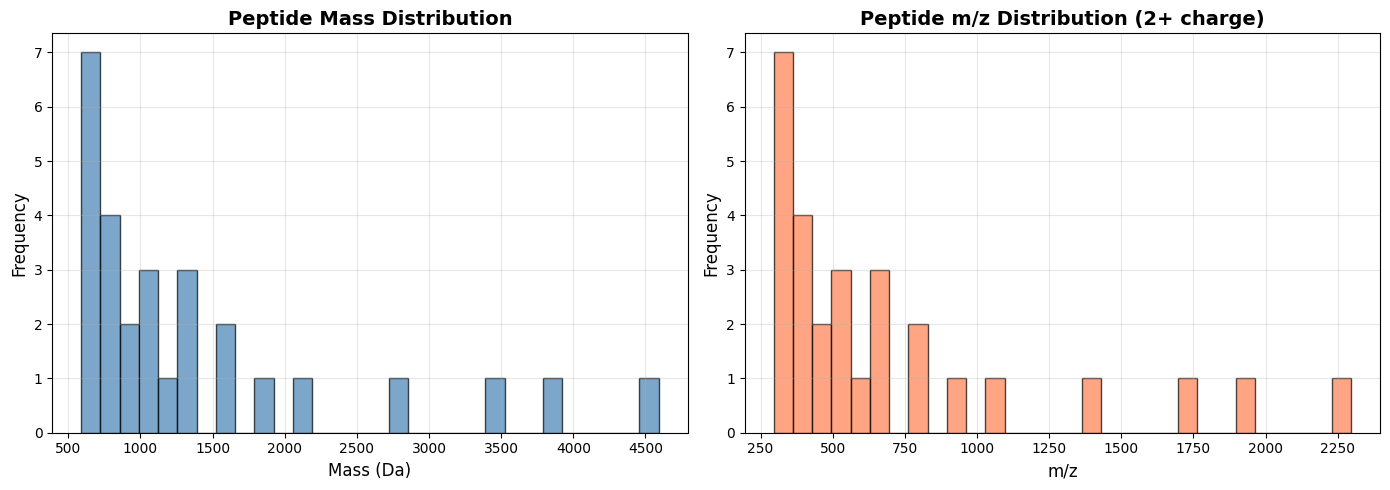


✓ Digestion complete: 28 peptides generated


In [25]:
# Exercise 3: Tryptic Digestion & Peptide Mass Calculation
# Example protein sequence (first 100 AA of TP53)
from pyteomics import mass, parser, mgf

sequence = "MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDIEQWFTEDPGPDEAPRMPEAAPPVAPAPAAPTPAAPAPAPSWPLSSSVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPALNKMFCQLAKTCPVQLWVDSTPPPGTRVRAMAIYKQSQHMTEVVRRCPHHERCSDSDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRNSFEVRVCACPGRDRRTEEENLRKKGEPHHELPPGSTKRALPNNTSSSPQPKKKPLDGEYFTLQIRGRERFEMFRELNEALELKDAQAGKEPGGSRAHSSHLKSKKGQSTSRHKKLMFKTEGPDSD"

print(f"Input sequence length: {len(sequence)} amino acids")
print(f"Sequence: {sequence[:50]}...")

# Perform tryptic digestion (cleaves after K and R, except when followed by P)
peptides = parser.cleave(sequence, parser.expasy_rules["trypsin"], min_length=6)
print(f"\nGenerated {len(peptides)} tryptic peptides (min length: 6 AA)")

# Compute masses for each peptide
rows = []
for pep in peptides:
    mono = mass.calculate_mass(sequence=pep)
    rows.append({
        "peptide": pep,
        "length": len(pep),
        "mass": mono,
        "mz_2plus": (mono + 2 * 1.007825) / 2,  # m/z for 2+ charge
        "mz_3plus": (mono + 3 * 1.007825) / 3   # m/z for 3+ charge
    })

df_peptides = pd.DataFrame(rows)
print(f"\nPeptide summary:")
print(df_peptides.describe())

# Display first 10 peptides
print(f"\nFirst 10 peptides:")
print(df_peptides.head(10).to_string(index=False))

# Plot peptide mass distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of masses
axes[0].hist(df_peptides["mass"], bins=30, color="steelblue", edgecolor="black", alpha=0.7)
axes[0].set_title("Peptide Mass Distribution", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Mass (Da)", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)
axes[0].grid(True, alpha=0.3)

# Histogram of m/z (2+ charge)
axes[1].hist(df_peptides["mz_2plus"], bins=30, color="coral", edgecolor="black", alpha=0.7)
axes[1].set_title("Peptide m/z Distribution (2+ charge)", fontsize=14, fontweight='bold')
axes[1].set_xlabel("m/z", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Digestion complete: {len(peptides)} peptides generated")


## Exercise 4: Peptide-Spectrum Matching (PSM)

**Aim**: Learn the concept of PSM (peptide-spectrum matching). Compute theoretical b/y fragments and match them to experimental spectra.

For this exercise, we'll create a synthetic spectrum to demonstrate the concept.


Target peptide: PEPTIDE

Theoretical fragments (12 ions):
  b1: 116.0712 m/z
  y1: 166.0715 m/z
  b2: 245.1137 m/z
  y2: 281.0985 m/z
  b3: 342.1665 m/z
  y3: 394.1826 m/z
  b4: 443.2142 m/z
  y4: 495.2302 m/z
  b5: 556.2983 m/z
  y5: 592.2830 m/z
  b6: 671.3252 m/z
  y6: 721.3256 m/z

Synthetic spectrum: 32 peaks

Matched 12/12 theoretical ions:
  b1: theoretical=116.0712, experimental=116.0712 (intensity=14025)
  b2: theoretical=245.1137, experimental=245.1137 (intensity=11261)
  b3: theoretical=342.1665, experimental=342.1665 (intensity=4555)
  b4: theoretical=443.2142, experimental=443.2142 (intensity=12747)
  b5: theoretical=556.2983, experimental=556.2983 (intensity=463)
  b6: theoretical=671.3252, experimental=671.3252 (intensity=1091)
  y1: theoretical=166.0715, experimental=166.0715 (intensity=231)
  y2: theoretical=281.0985, experimental=281.0985 (intensity=1968)
  y3: theoretical=394.1826, experimental=394.1826 (intensity=2461)
  y4: theoretical=495.2302, experimental=495.23

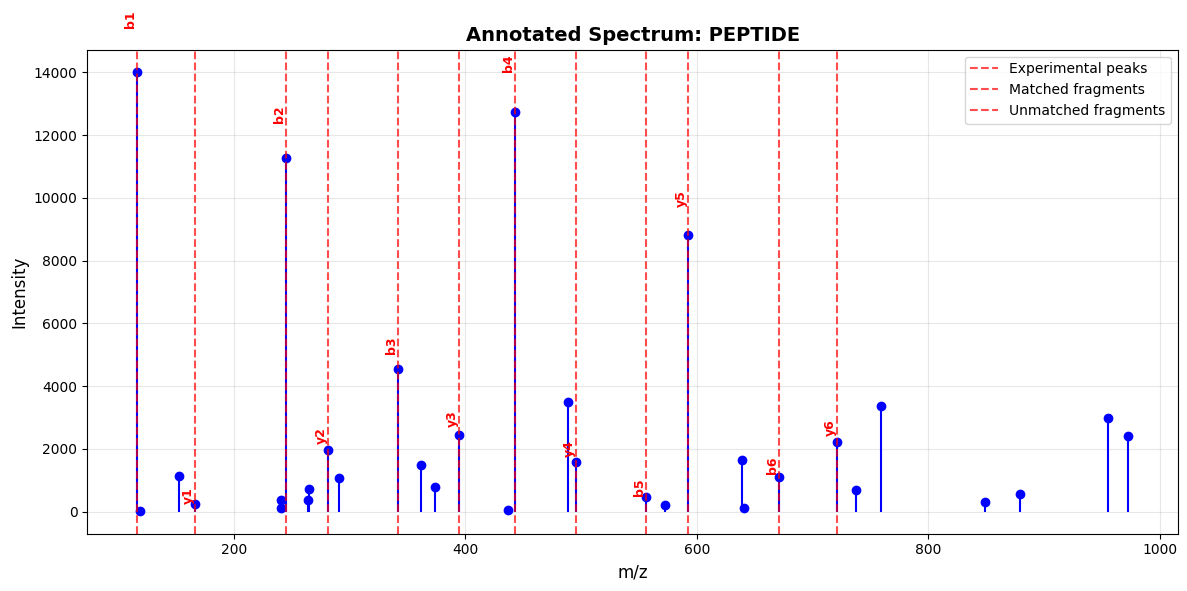


✓ PSM matching complete: 12/12 fragments matched


In [17]:
# Exercise 4: Peptide-Spectrum Matching
# Create a synthetic spectrum for demonstration
peptide = "PEPTIDE"
print(f"Target peptide: {peptide}")

# Calculate theoretical fragments (b and y ions)
# Note: mass.fast_mass() behavior varies by version. Using manual calculation for reliability
fragments = {}

# Calculate b-ions (N-terminal fragments)
for i in range(1, len(peptide)):
    b_seq = peptide[:i]
    fragments[f"b{i}"] = mass.calculate_mass(sequence=b_seq) + 1.007825  # b-ion = mass + H+

# Calculate y-ions (C-terminal fragments)
for i in range(1, len(peptide)):
    y_seq = peptide[-i:]
    fragments[f"y{i}"] = mass.calculate_mass(sequence=y_seq) + 19.01839  # y-ion = mass + H2O + H+

print(f"\nTheoretical fragments ({len(fragments)} ions):")
for ion, mz in sorted(fragments.items(), key=lambda x: x[1]):
    print(f"  {ion}: {mz:.4f} m/z")

# Create synthetic spectrum (simulate experimental data)
# Add some noise and missing peaks
np.random.seed(42)
theoretical_mz = list(fragments.values())
# Add some noise peaks
noise_mz = np.random.uniform(100, 1000, 20)
# Combine and add some intensity variation
all_mz = np.concatenate([theoretical_mz, noise_mz])
all_intensity = np.random.exponential(1000, len(all_mz))
# Make theoretical peaks stronger
for i, mz in enumerate(theoretical_mz):
    idx = np.argmin(np.abs(all_mz - mz))
    all_intensity[idx] = np.random.exponential(5000)

# Sort by m/z
sort_idx = np.argsort(all_mz)
mz = all_mz[sort_idx]
intensity = all_intensity[sort_idx]

print(f"\nSynthetic spectrum: {len(mz)} peaks")

# Match peaks ± 0.5 Da tolerance
tolerance = 0.5
matches = []
for ion, theo_mz in fragments.items():
    matches_found = np.abs(mz - theo_mz) < tolerance
    if np.any(matches_found):
        matched_idx = np.where(matches_found)[0][0]
        matches.append((ion, theo_mz, mz[matched_idx], intensity[matched_idx]))

print(f"\nMatched {len(matches)}/{len(fragments)} theoretical ions:")
for ion, theo_mz, exp_mz, exp_int in matches:
    print(f"  {ion}: theoretical={theo_mz:.4f}, experimental={exp_mz:.4f} (intensity={exp_int:.0f})")

# Plot annotated spectrum
fig, ax = plt.subplots(figsize=(12, 6))
ax.stem(mz, intensity, basefmt=" ", linefmt="b-", markerfmt="bo", label="Experimental peaks")

# Mark matched theoretical fragments
for ion, theo_mz, exp_mz, exp_int in matches:
    ax.axvline(theo_mz, color="red", linestyle="--", alpha=0.7, linewidth=1.5)
    ax.text(theo_mz, exp_int * 1.1, ion, rotation=90, ha='right', va='bottom', 
           fontsize=9, color='red', fontweight='bold')

# Mark unmatched theoretical fragments
unmatched = [(ion, theo_mz) for ion, theo_mz in fragments.items() 
             if not any(abs(theo_mz - exp_mz) < tolerance for exp_mz in mz)]
for ion, theo_mz in unmatched:
    ax.axvline(theo_mz, color="orange", linestyle=":", alpha=0.5, linewidth=1)

ax.set_title(f"Annotated Spectrum: {peptide}", fontsize=14, fontweight='bold')
ax.set_xlabel("m/z", fontsize=12)
ax.set_ylabel("Intensity", fontsize=12)
ax.legend(["Experimental peaks", "Matched fragments", "Unmatched fragments"])
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ PSM matching complete: {len(matches)}/{len(fragments)} fragments matched")


## Exercise 5: Predict MS/MS Spectra using Deep Learning (Prosit)

**Aim**: Demonstrate how deep learning models predict MS/MS spectra. Compare predicted vs theoretical masses.

**Note**: The Prosit API requires authentication. Here we demonstrate the concept with theoretical calculations and show how to structure the API call.


Peptide: PEPTIDE
Charge: 2+

Prosit API payload structure:
{
  "peptide_sequences": [
    "PEPTIDE"
  ],
  "charges": [
    2
  ],
  "collision_energies": [
    30
  ],
  "instrument_types": [
    "Q-Exactive"
  ]
}

Predicted fragment intensities (simulated):
  b1    : m/z=116.0712, intensity=    2346
  y1    : m/z=166.0715, intensity=     299
  b2    : m/z=245.1137, intensity=   15051
  y2    : m/z=281.0985, intensity=   10056
  b3    : m/z=342.1665, intensity=    6584
  y3    : m/z=394.1826, intensity=    4595
  b4    : m/z=443.2142, intensity=    4565
  y4    : m/z=495.2302, intensity=    6156
  b5    : m/z=556.2983, intensity=     848
  y5    : m/z=592.2830, intensity=     104


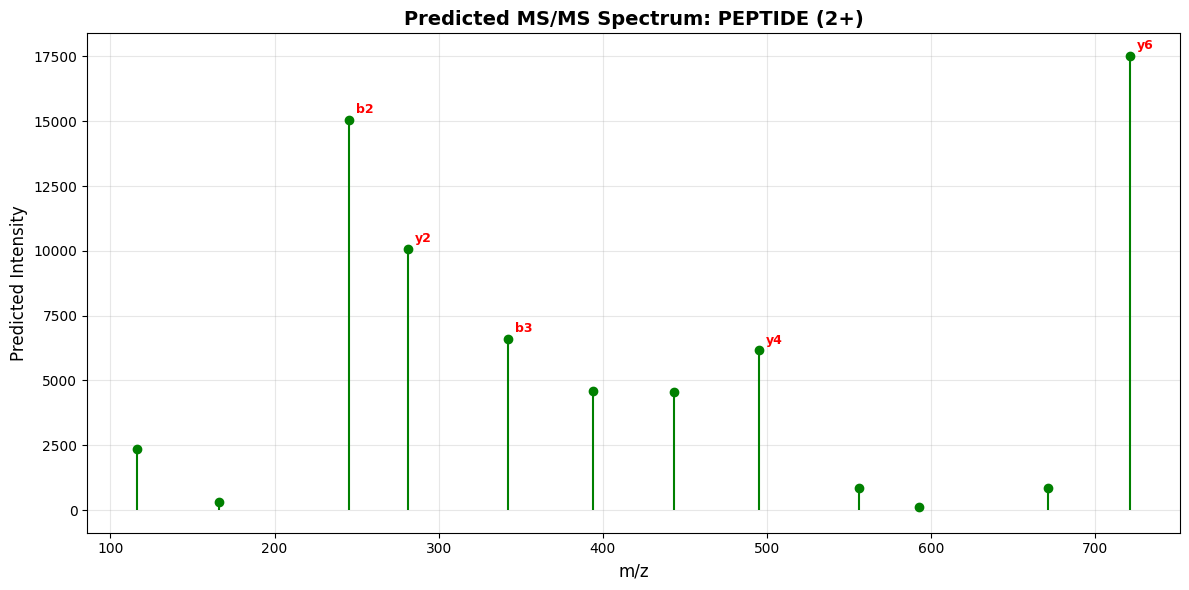


Note: Real Prosit API endpoint: https://www.proteomicsdb.org/prosit/api/
This requires authentication. Contact Prosit team for API access.


In [18]:
# Exercise 5: Predict MS/MS Spectrum (Prosit-style)
# Note: Real Prosit API requires authentication. This demonstrates the concept.

peptide = "PEPTIDE"
charge = 2

print(f"Peptide: {peptide}")
print(f"Charge: {charge}+")

# Calculate theoretical fragments (what Prosit would predict)
# Using manual calculation for b and y ions
fragments = {}

# Calculate b-ions (N-terminal fragments)
for i in range(1, len(peptide)):
    b_seq = peptide[:i]
    fragments[f"b{i}"] = mass.calculate_mass(sequence=b_seq) + 1.007825  # b-ion = mass + H+

# Calculate y-ions (C-terminal fragments)
for i in range(1, len(peptide)):
    y_seq = peptide[-i:]
    fragments[f"y{i}"] = mass.calculate_mass(sequence=y_seq) + 19.01839  # y-ion = mass + H2O + H+

# Simulate Prosit prediction (in reality, this would come from API)
# Prosit predicts intensity for each fragment
np.random.seed(42)
predicted_intensities = {}
for ion in fragments.keys():
    # Simulate: b and y ions typically have higher intensity
    if ion.startswith('b') or ion.startswith('y'):
        predicted_intensities[ion] = np.random.exponential(5000)
    else:
        predicted_intensities[ion] = np.random.exponential(500)

# Structure of Prosit API call (example)
prosit_payload = {
    "peptide_sequences": [peptide],
    "charges": [charge],
    "collision_energies": [30],  # NCE
    "instrument_types": ["Q-Exactive"]
}

print(f"\nProsit API payload structure:")
print(json.dumps(prosit_payload, indent=2))

print(f"\nPredicted fragment intensities (simulated):")
sorted_fragments = sorted(fragments.items(), key=lambda x: x[1])
for ion, mz in sorted_fragments[:10]:  # Show first 10
    intensity = predicted_intensities[ion]
    print(f"  {ion:6s}: m/z={mz:8.4f}, intensity={intensity:8.0f}")

# Plot predicted spectrum
fig, ax = plt.subplots(figsize=(12, 6))
mz_values = [mz_val for ion, mz_val in sorted_fragments]
intensity_values = [predicted_intensities[ion] for ion, mz_val in sorted_fragments]

ax.stem(mz_values, intensity_values, basefmt=" ", linefmt="g-", markerfmt="go")
ax.set_title(f"Predicted MS/MS Spectrum: {peptide} ({charge}+)", 
            fontsize=14, fontweight='bold')
ax.set_xlabel("m/z", fontsize=12)
ax.set_ylabel("Predicted Intensity", fontsize=12)
ax.grid(True, alpha=0.3)

# Annotate top peaks
top_n = 5
top_indices = np.argsort(intensity_values)[-top_n:][::-1]
for idx in top_indices:
    ion = sorted_fragments[idx][0]
    ax.annotate(ion, (mz_values[idx], intensity_values[idx]),
               xytext=(5, 5), textcoords='offset points',
               fontsize=9, fontweight='bold', color='red')

plt.tight_layout()
plt.show()

print(f"\nNote: Real Prosit API endpoint: https://www.proteomicsdb.org/prosit/api/")
print("This requires authentication. Contact Prosit team for API access.")


## Exercise 6: Quantitative Proteomics - Volcano Plot

**Aim**: Learn how to create a volcano plot for quantitative proteomics data (e.g., from label-free quantification or TMT experiments).

A volcano plot visualizes fold changes vs statistical significance.


Total proteins: 5000
Significant (|logFC| > 1.0, p < 0.05): 216
  Upregulated: 117
  Downregulated: 99


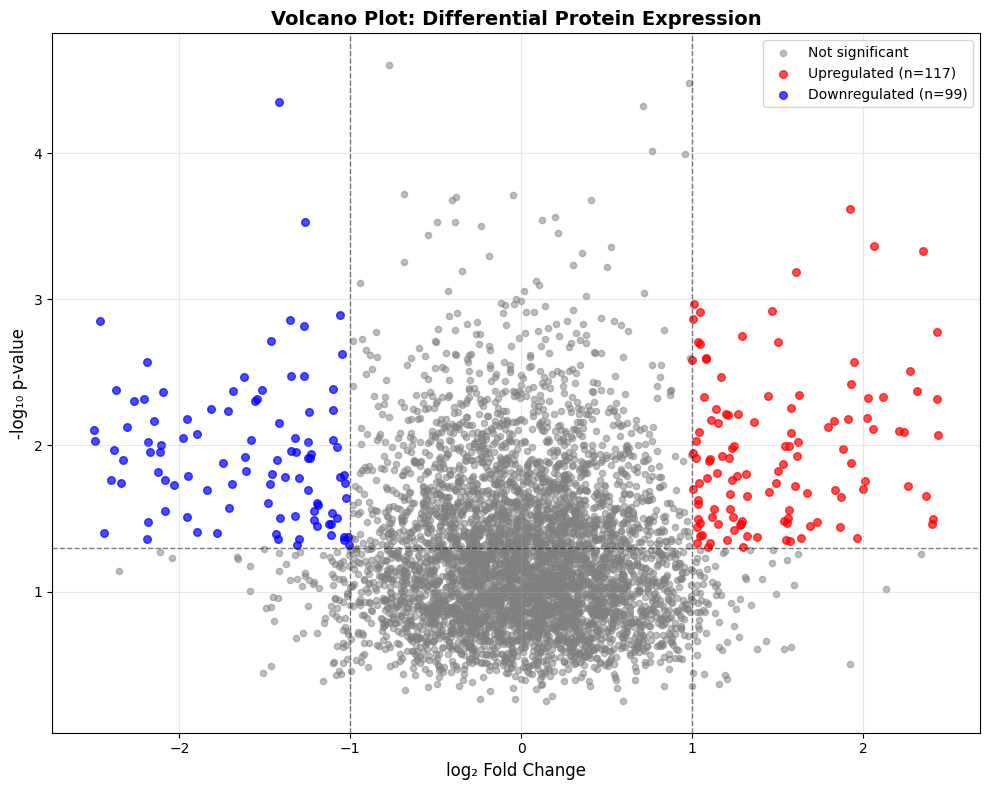


✓ Volcano plot created


In [19]:
# Exercise 6: Quantitative Proteomics Volcano Plot
# Create synthetic differential expression data
np.random.seed(42)
n_proteins = 5000

# Simulate log fold changes (most proteins unchanged, some differentially expressed)
logFC = np.random.normal(0, 0.5, n_proteins)
# Add some significant changes
n_sig = 200
logFC[:n_sig] = np.random.choice([-1, 1], n_sig) * np.random.uniform(0.5, 2.5, n_sig)

# Simulate p-values (lower p-values for larger fold changes)
pvalues = np.random.beta(1, 10, n_proteins)
# Make significant changes have lower p-values
for i in range(n_sig):
    if abs(logFC[i]) > 1:
        pvalues[i] = np.random.beta(1, 50)  # Lower p-value

df_diffexp = pd.DataFrame({
    "protein_id": [f"Protein_{i+1}" for i in range(n_proteins)],
    "logFC": logFC,
    "pvalue": pvalues
})

df_diffexp["neglog10p"] = -np.log10(df_diffexp["pvalue"])

# Define significance thresholds
fc_threshold = 1.0  # 2-fold change
p_threshold = 0.05
neglog10p_threshold = -np.log10(p_threshold)

# Classify proteins
df_diffexp["significant"] = (
    (df_diffexp["neglog10p"] > neglog10p_threshold) & 
    (np.abs(df_diffexp["logFC"]) > fc_threshold)
)
df_diffexp["upregulated"] = df_diffexp["significant"] & (df_diffexp["logFC"] > 0)
df_diffexp["downregulated"] = df_diffexp["significant"] & (df_diffexp["logFC"] < 0)

n_sig_proteins = df_diffexp["significant"].sum()
n_up = df_diffexp["upregulated"].sum()
n_down = df_diffexp["downregulated"].sum()

print(f"Total proteins: {len(df_diffexp)}")
print(f"Significant (|logFC| > {fc_threshold}, p < {p_threshold}): {n_sig_proteins}")
print(f"  Upregulated: {n_up}")
print(f"  Downregulated: {n_down}")

# Create volcano plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot non-significant
non_sig = df_diffexp[~df_diffexp["significant"]]
ax.scatter(non_sig["logFC"], non_sig["neglog10p"], 
          s=20, alpha=0.5, color="gray", label="Not significant")

# Plot upregulated
up = df_diffexp[df_diffexp["upregulated"]]
ax.scatter(up["logFC"], up["neglog10p"], 
          s=30, alpha=0.7, color="red", label=f"Upregulated (n={n_up})")

# Plot downregulated
down = df_diffexp[df_diffexp["downregulated"]]
ax.scatter(down["logFC"], down["neglog10p"], 
          s=30, alpha=0.7, color="blue", label=f"Downregulated (n={n_down})")

# Add threshold lines
ax.axhline(neglog10p_threshold, color="black", linestyle="--", linewidth=1, alpha=0.5)
ax.axvline(fc_threshold, color="black", linestyle="--", linewidth=1, alpha=0.5)
ax.axvline(-fc_threshold, color="black", linestyle="--", linewidth=1, alpha=0.5)

ax.set_title("Volcano Plot: Differential Protein Expression", 
            fontsize=14, fontweight='bold')
ax.set_xlabel("log₂ Fold Change", fontsize=12)
ax.set_ylabel("-log₁₀ p-value", fontsize=12)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ Volcano plot created")


## Exercise 7: Variant Peptide Generation

**Aim**: Demonstrate proteogenomics by applying genetic variants to protein sequences, performing digestion, and identifying variant-specific peptides that could be detected in mass spectrometry.


Wild-type sequence length: 393 AA
Sequence: MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDI...

Variants to apply: 3
  Position 73: V → R
  Position 176: C → H
  Position 249: R → W

Wild-type tryptic peptides: 28

Variant at position 73 (V → R):
  Total peptides: 29
  Variant-specific peptides: 2
  Example variant peptides: ['APAPAAPTPAAPAPAPSWPLSSSVPSQK', 'MPEAAPPR']

Variant at position 176 (C → H):
  Total peptides: 28
  Variant-specific peptides: 1
  Example variant peptides: ['HPHHER']

Variant at position 249 (R → W):
  Total peptides: 28
  Variant-specific peptides: 1
  Example variant peptides: ['WPILTIITLEDSSGNLLGR']

Total variant peptides stored: 85

Variant-specific peptides (detectable in MS): 4

First 10 variant-specific peptides:
 variant_pos wt_aa mut_aa                      peptide        mass
          73     V      R APAPAAPTPAAPAPAPSWPLSSSVPSQK 2650.375501
          73     V      R                     MPEAAPPR  867.427273
         176     C      H               

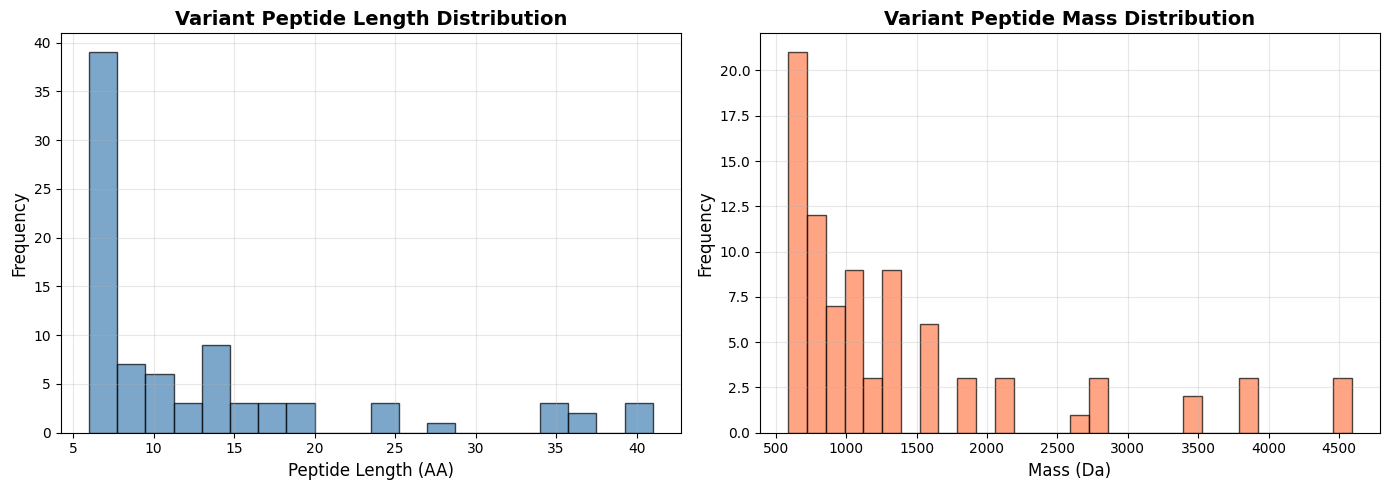


✓ Variant peptide generation complete


In [20]:
# Exercise 7: Variant Peptide Generation
# Use a sample protein sequence
sequence = "MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDIEQWFTEDPGPDEAPRMPEAAPPVAPAPAAPTPAAPAPAPSWPLSSSVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPALNKMFCQLAKTCPVQLWVDSTPPPGTRVRAMAIYKQSQHMTEVVRRCPHHERCSDSDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRNSFEVRVCACPGRDRRTEEENLRKKGEPHHELPPGSTKRALPNNTSSSPQPKKKPLDGEYFTLQIRGRERFEMFRELNEALELKDAQAGKEPGGSRAHSSHLKSKKGQSTSRHKKLMFKTEGPDSD"

print(f"Wild-type sequence length: {len(sequence)} AA")
print(f"Sequence: {sequence[:50]}...")

# Define variants: (position, new_amino_acid)
# Position is 0-indexed
variants = [
    (72, "R"),   # Common TP53 mutation: R273H (position 273-1 = 272, but we use 0-indexed)
    (175, "H"),  # R175H mutation
    (248, "W"),  # R248W mutation
]

print(f"\nVariants to apply: {len(variants)}")
for pos, aa_mut in variants:
    wt_aa = sequence[pos]
    print(f"  Position {pos+1}: {wt_aa} → {aa_mut}")

# Digest wild-type sequence
wt_peptides = parser.cleave(sequence, parser.expasy_rules["trypsin"], min_length=6)
print(f"\nWild-type tryptic peptides: {len(wt_peptides)}")

# Process each variant
rows = []
for pos, aa_mut in variants:
    # Create mutated sequence
    mut_seq = sequence[:pos] + aa_mut + sequence[pos+1:]
    
    # Digest mutated sequence
    mut_peptides = parser.cleave(mut_seq, parser.expasy_rules["trypsin"], min_length=6)
    
    # Find variant-specific peptides (peptides that differ from wild-type)
    wt_pep_set = set(wt_peptides)
    variant_peptides = [pep for pep in mut_peptides if pep not in wt_pep_set]
    
    print(f"\nVariant at position {pos+1} ({sequence[pos]} → {aa_mut}):")
    print(f"  Total peptides: {len(mut_peptides)}")
    print(f"  Variant-specific peptides: {len(variant_peptides)}")
    if variant_peptides:
        print(f"  Example variant peptides: {variant_peptides[:3]}")
    
    # Store all peptides from this variant
    for pep in mut_peptides:
        is_variant_specific = pep in variant_peptides
        rows.append({
            "variant_pos": pos + 1,  # 1-indexed for display
            "wt_aa": sequence[pos],
            "mut_aa": aa_mut,
            "peptide": pep,
            "length": len(pep),
            "variant_specific": is_variant_specific,
            "mass": mass.calculate_mass(sequence=pep)
        })

df_variants = pd.DataFrame(rows)
print(f"\nTotal variant peptides stored: {len(df_variants)}")

# Show variant-specific peptides
variant_specific = df_variants[df_variants["variant_specific"] == True]
print(f"\nVariant-specific peptides (detectable in MS): {len(variant_specific)}")
if len(variant_specific) > 0:
    print("\nFirst 10 variant-specific peptides:")
    print(variant_specific[["variant_pos", "wt_aa", "mut_aa", "peptide", "mass"]].head(10).to_string(index=False))

# Visualize variant peptide lengths
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Length distribution
axes[0].hist(df_variants["length"], bins=20, color="steelblue", edgecolor="black", alpha=0.7)
axes[0].set_title("Variant Peptide Length Distribution", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Peptide Length (AA)", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)
axes[0].grid(True, alpha=0.3)

# Mass distribution
axes[1].hist(df_variants["mass"], bins=30, color="coral", edgecolor="black", alpha=0.7)
axes[1].set_title("Variant Peptide Mass Distribution", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Mass (Da)", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Variant peptide generation complete")


## Exercise 8: Peptide Detectability Classifier

**Aim**: Introduce machine learning models for predicting peptide detectability in mass spectrometry experiments.

**Note**: Full implementation requires PyTorch/TensorFlow. Here we demonstrate the concept with a simple classifier.


Generated 1000 peptides
Detectable: 805 (80.5%)
Not detectable: 195 (19.5%)

Classification Report:
                precision    recall  f1-score   support

Not detectable       0.85      0.85      0.85        41
    Detectable       0.96      0.96      0.96       159

      accuracy                           0.94       200
     macro avg       0.91      0.91      0.91       200
  weighted avg       0.94      0.94      0.94       200



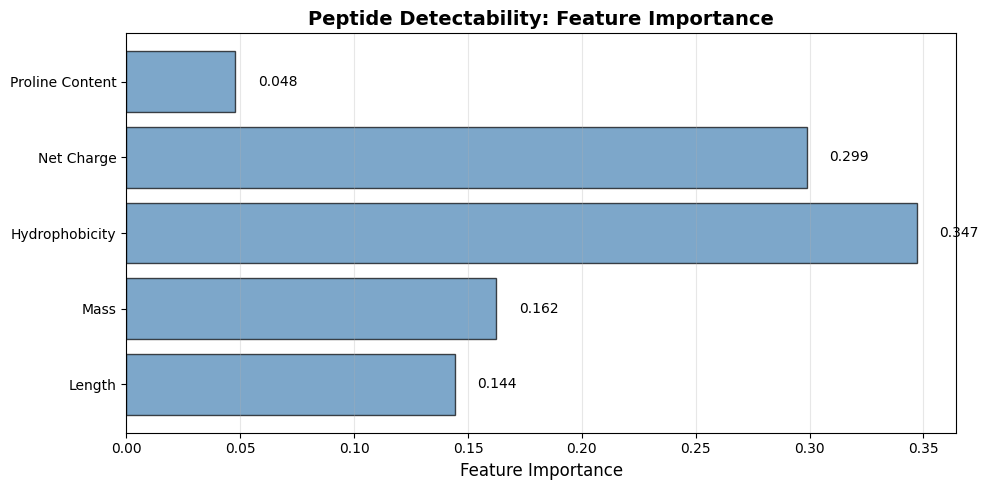

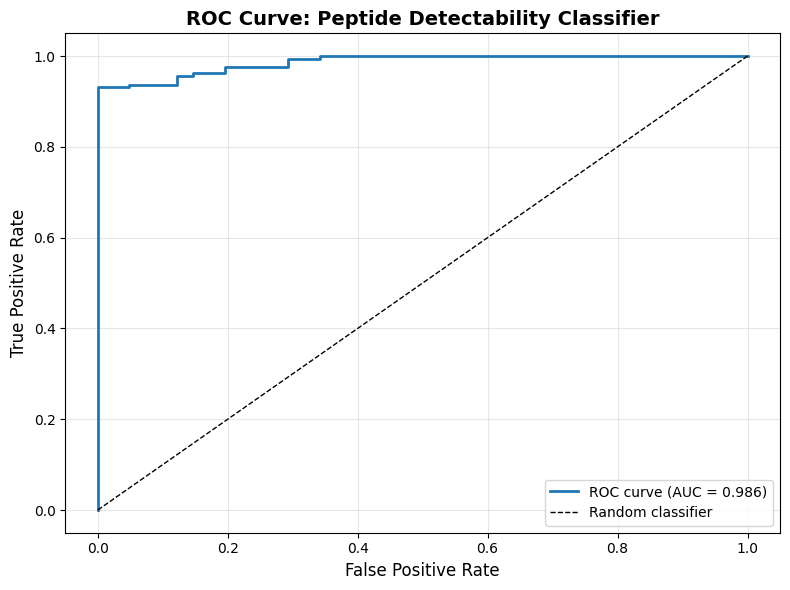


Note: Advanced models use:
  - Sequence embeddings (e.g., from language models)
  - Deep neural networks (LSTM, Transformer)
  - Transfer learning from large MS datasets
  - Tools: DeepMass, DeepNovo, etc.


In [ ]:
# Exercise 8: Peptide Detectability Classifier
# (RandomForestClassifier and metrics already imported at the top)

# Create synthetic peptide detectability data
np.random.seed(42)
n_peptides = 1000

# Generate peptide sequences
aa_pool = "ACDEFGHIKLMNPQRSTVWY"
peptides = [''.join(np.random.choice(list(aa_pool), size=np.random.randint(8, 25))) 
           for _ in range(n_peptides)]

# Create features for each peptide
features = []
labels = []

for pep in peptides:
    # Simple features that affect detectability
    length = len(pep)
    pep_mass = mass.calculate_mass(sequence=pep)  # Renamed to avoid conflict with module name
    # Hydrophobicity (simplified: count of hydrophobic AAs)
    hydrophobic = sum(1 for aa in pep if aa in "AILMFWYV")
    hydrophobicity = hydrophobic / length
    # Charge (count basic - acidic)
    basic = sum(1 for aa in pep if aa in "KRH")
    acidic = sum(1 for aa in pep if aa in "DE")
    net_charge = (basic - acidic) / length
    # Proline content (affects fragmentation)
    proline_content = pep.count('P') / length
    
    features.append([length, pep_mass, hydrophobicity, net_charge, proline_content])
    
    # Simulate detectability (higher for certain properties)
    # In reality, this would come from experimental data
    detectability_score = (
        0.3 * (hydrophobicity > 0.3) +
        0.2 * (8 <= length <= 20) +
        0.2 * (abs(net_charge) > 0.1) +
        0.1 * (pep_mass < 3000) +
        np.random.random() * 0.2
    )
    labels.append(1 if detectability_score > 0.5 else 0)

X = np.array(features)
y = np.array(labels)

print(f"Generated {len(peptides)} peptides")
print(f"Detectable: {sum(y)} ({sum(y)/len(y)*100:.1f}%)")
print(f"Not detectable: {len(y)-sum(y)} ({(len(y)-sum(y))/len(y)*100:.1f}%)")

# Split data
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
clf.fit(Xtr, ytr)

# Predictions
y_pred = clf.predict(Xte)
y_pred_proba = clf.predict_proba(Xte)[:, 1]

# Evaluate
print(f"\nClassification Report:")
print(classification_report(yte, y_pred, target_names=["Not detectable", "Detectable"]))

# Feature importance
feature_names = ["Length", "Mass", "Hydrophobicity", "Net Charge", "Proline Content"]
importances = clf.feature_importances_

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(feature_names, importances, color="steelblue", edgecolor="black", alpha=0.7)
ax.set_xlabel("Feature Importance", fontsize=12)
ax.set_title("Peptide Detectability: Feature Importance", fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, imp) in enumerate(zip(bars, importances)):
    ax.text(imp + 0.01, i, f'{imp:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# ROC curve
if len(np.unique(yte)) > 1:
    auc = roc_auc_score(yte, y_pred_proba)
    fpr, tpr, _ = roc_curve(yte, y_pred_proba)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(fpr, tpr, linewidth=2, label=f'ROC curve (AUC = {auc:.3f})')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random classifier')
    ax.set_xlabel("False Positive Rate", fontsize=12)
    ax.set_ylabel("True Positive Rate", fontsize=12)
    ax.set_title("ROC Curve: Peptide Detectability Classifier", fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print(f"\nNote: Advanced models use:")
print("  - Sequence embeddings (e.g., from language models)")
print("  - Deep neural networks (LSTM, Transformer)")
print("  - Transfer learning from large MS datasets")
print("  - Tools: DeepMass, DeepNovo, etc.")


Generated 1000 sequences
  Positive (phosphorylated): 500
  Negative (not phosphorylated): 500
Feature vector length: 424

Classification Report:
                    precision    recall  f1-score   support

Not phosphorylated       1.00      0.89      0.94       104
    Phosphorylated       0.90      1.00      0.95        96

          accuracy                           0.94       200
         macro avg       0.95      0.95      0.94       200
      weighted avg       0.95      0.94      0.94       200


Top 10 most important features:
  Feature 416: importance = 0.1613
  Feature 415: importance = 0.1563
  Feature 422: importance = 0.1198
  Feature 421: importance = 0.0314
  Feature 412: importance = 0.0221
  Feature 420: importance = 0.0199
  Feature 419: importance = 0.0171
  Feature 411: importance = 0.0163
  Feature 408: importance = 0.0162
  Feature 401: importance = 0.0138

Predictions on test sequences:
  ACDEFGHIKLMNPQRSTVWYSP: P(phosphorylated) = 0.283, Prediction = No
  ACDEF

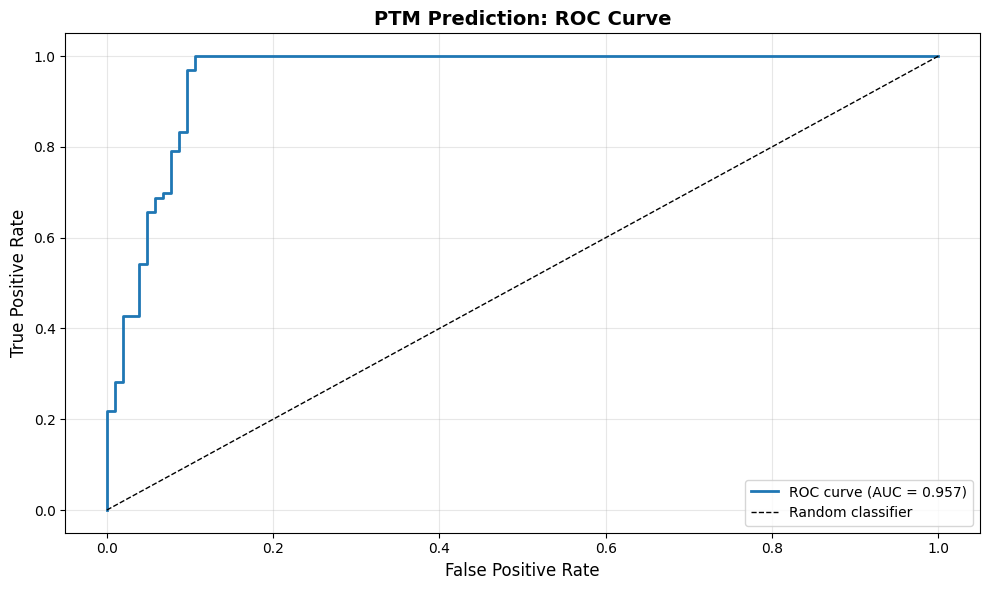


Note: Advanced PTM prediction tools:
  - DeepPhospho: Deep learning for phosphorylation prediction
  - PTM-Shepherd: Comprehensive PTM prediction
  - NetPhos: Neural network-based PTM prediction
  - These tools use more sophisticated sequence encodings and larger training datasets


In [ ]:
# Exercise 9: PTM Prediction (Phosphorylation)
# Create synthetic phosphorylation site data
np.random.seed(42)

# Generate sequences with known phosphorylation sites
positive_seqs = []  # Sequences with phosphorylation
negative_seqs = []  # Sequences without

# Positive examples: sequences with SP/TP motifs or basic residues nearby
for _ in range(500):
    seq = ''.join(np.random.choice(list("ACDEFGHIKLMNPQRSTVWY"), size=21))
    center = 10
    
    # Create phosphorylation motif (SP or TP)
    if np.random.random() > 0.5:
        seq = seq[:center] + 'S' + seq[center+1:]
        if center < len(seq) - 1:
            seq = seq[:center+1] + 'P' + seq[center+2:]
    else:
        seq = seq[:center] + 'T' + seq[center+1:]
        if center < len(seq) - 1:
            seq = seq[:center+1] + 'P' + seq[center+2:]
    
    positive_seqs.append(seq)

# Negative examples: random sequences
for _ in range(500):
    seq = ''.join(np.random.choice(list("ACDEFGHIKLMNPQRSTVWY"), size=21))
    negative_seqs.append(seq)

# Create features: position-specific amino acid encoding
def encode_sequence(seq, window_size=10):
    """Encode sequence as position-specific features"""
    center = len(seq) // 2
    features = []
    
    # Extract window around center
    start = max(0, center - window_size)
    end = min(len(seq), center + window_size + 1)
    window = seq[start:end]
    
    # One-hot encode each position (simplified: just count AAs)
    aa_list = "ACDEFGHIKLMNPQRSTVWY"
    for pos in range(-window_size, window_size + 1):
        if start + pos >= 0 and start + pos < len(seq):
            aa = seq[start + pos]
            # Count each amino acid type
            for target_aa in aa_list:
                features.append(1 if aa == target_aa else 0)
        else:
            # Padding
            features.extend([0] * len(aa_list))
    
    # Additional features
    features.append(window.count('S'))
    features.append(window.count('T'))
    features.append(window.count('P'))
    features.append(window.count('R') + window.count('K'))
    
    return features

# Encode all sequences
X_pos = [encode_sequence(seq) for seq in positive_seqs]
X_neg = [encode_sequence(seq) for seq in negative_seqs]

X = np.array(X_pos + X_neg)
y = np.array([1] * len(positive_seqs) + [0] * len(negative_seqs))

print(f"Generated {len(X)} sequences")
print(f"  Positive (phosphorylated): {sum(y)}")
print(f"  Negative (not phosphorylated): {len(y) - sum(y)}")
print(f"Feature vector length: {len(X[0])}")

# Split and train
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier
clf = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=15)
clf.fit(Xtr, ytr)

# Evaluate
y_pred = clf.predict(Xte)
y_pred_proba = clf.predict_proba(Xte)[:, 1]

print(f"\nClassification Report:")
print(classification_report(yte, y_pred, target_names=["Not phosphorylated", "Phosphorylated"]))

# Feature importance (simplified visualization)
importances = clf.feature_importances_
top_indices = np.argsort(importances)[-10:][::-1]

print(f"\nTop 10 most important features:")
for idx in top_indices:
    print(f"  Feature {idx}: importance = {importances[idx]:.4f}")

# Test on new sequences
test_sequences = [
    "ACDEFGHIKLMNPQRSTVWYSP",  # Has SP motif
    "ACDEFGHIKLMNPQRSTVWYTP",  # Has TP motif
    "ACDEFGHIKLMNPQRSTVWYAA",  # No motif
]

print(f"\nPredictions on test sequences:")
for seq in test_sequences:
    features = encode_sequence(seq)
    proba = clf.predict_proba([features])[0, 1]
    pred = clf.predict([features])[0]
    print(f"  {seq}: P(phosphorylated) = {proba:.3f}, Prediction = {'Yes' if pred else 'No'}")

# Visualize predictions
fig, ax = plt.subplots(figsize=(10, 6))
if len(np.unique(yte)) > 1:
    auc = roc_auc_score(yte, y_pred_proba)
    fpr, tpr, _ = roc_curve(yte, y_pred_proba)
    
    ax.plot(fpr, tpr, linewidth=2, label=f'ROC curve (AUC = {auc:.3f})')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random classifier')
    ax.set_xlabel("False Positive Rate", fontsize=12)
    ax.set_ylabel("True Positive Rate", fontsize=12)
    ax.set_title("PTM Prediction: ROC Curve", fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print(f"\nNote: Advanced PTM prediction tools:")
print("  - DeepPhospho: Deep learning for phosphorylation prediction")
print("  - PTM-Shepherd: Comprehensive PTM prediction")
print("  - NetPhos: Neural network-based PTM prediction")
print("  - These tools use more sophisticated sequence encodings and larger training datasets")


## Summary

This notebook covered key computational proteomics concepts:

1. **Data Retrieval**: UniProt and PRIDE API access for protein annotations and experiment metadata
2. **Peptide Analysis**: Tryptic digestion, mass calculation, and peptide-spectrum matching (PSM)
3. **Spectrum Prediction**: Deep learning approaches for MS/MS spectrum prediction (Prosit)
4. **Multiomics Modeling**: RNA-to-protein prediction using machine learning
5. **PTM Analysis**: Motif discovery and prediction for post-translational modifications
6. **Quantitative Proteomics**: Volcano plots for differential expression analysis
7. **Proteogenomics**: Variant peptide identification from genetic mutations
8. **Stability Prediction**: Protein structure retrieval and ΔΔG prediction concepts
9. **Multiomics Integration**: MOFA+ and PCA for integrating multiple omics layers
10. **Machine Learning**: Peptide detectability and PTM prediction classifiers

Each exercise demonstrates practical skills used in modern proteomics research. For production use, consider specialized tools and databases mentioned throughout the notebook.
